In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from tensorflow.keras.applications import InceptionV3
from keras.models import Model
from tensorflow.keras import optimizers , layers, applications

In [3]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

In [4]:
plt.style.use('seaborn')

def plot_history(model_history):

    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    x = range(1, len(train_acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig("figure.jpg")
    plt.show()

<ipython-input-4-dabd55f65790>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### My Implementation

In [5]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/drive/MyDrive/FYP/Alzheimer'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Non Demented
processing class directory  Very Mild Demented
processing class directory  Moderate Demented
processing class directory  Mild Demented
improper image files are listed below
/content/drive/MyDrive/FYP/Alzheimer/Non Demented/Tr-no_1001.jpg


In [6]:
len(bad_file_list)

1

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/FYP/Alzheimer",
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/FYP/Alzheimer",
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

for x, y in train_ds.take(1):
  print('Image --> ', x.shape, 'Label --> ',  y.shape)

Found 5929 files belonging to 4 classes.
Using 4151 files for training.
Found 5929 files belonging to 4 classes.
Using 1778 files for validation.
Image -->  (32, 224, 224, 3) Label -->  (32,)


In [8]:
class_names = train_ds.class_names
print(class_names)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']


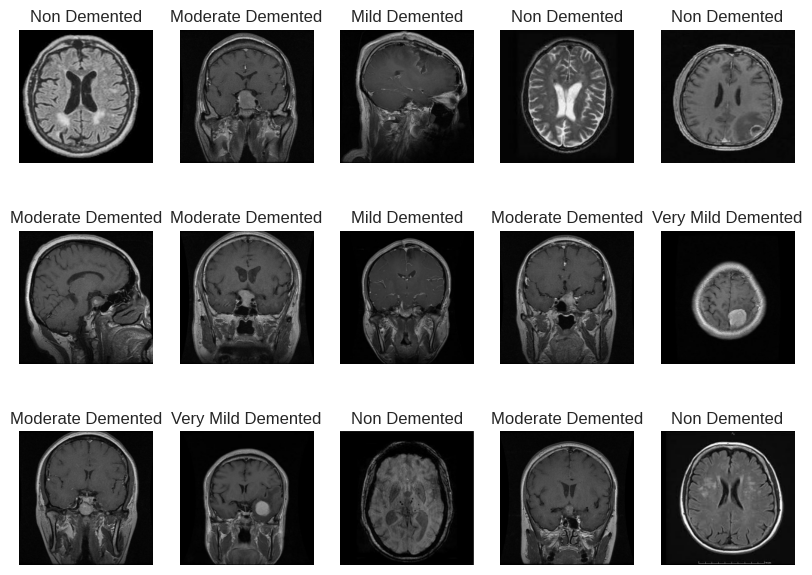

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.97212857


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
model = keras.models.Sequential([
    InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3)),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')  # Replace NUM_CLASSES with the number of classes in your task
])

87910968/87910968 [==============================] - 0s 0us/step


In [14]:
import tensorflow as tf
from tensorflow.python.ops import array_ops

def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)

    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)

    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)




In [15]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


130/130 [==============================] - 99s 333ms/step - loss: 1.0770 - accuracy: 0.5483 - val_loss: 0.6100 - val_accuracy: 0.7773
Epoch 2/10
130/130 [==============================] - 35s 265ms/step - loss: 0.4172 - accuracy: 0.8591 - val_loss: 0.2866 - val_accuracy: 0.8948
Epoch 3/10
130/130 [==============================] - 36s 276ms/step - loss: 0.1787 - accuracy: 0.9434 - val_loss: 0.2117 - val_accuracy: 0.9246
Epoch 4/10
130/130 [==============================] - 37s 282ms/step - loss: 0.0676 - accuracy: 0.9855 - val_loss: 0.1921 - val_accuracy: 0.9342
Epoch 5/10
130/130 [==============================] - 36s 274ms/step - loss: 0.0254 - accuracy: 0.9974 - val_loss: 0.1894 - val_accuracy: 0.9370
Epoch 6/10
130/130 [==============================] - 35s 272ms/step - loss: 0.0109 - accuracy: 0.9995 - val_loss: 0.1992 - val_accuracy: 0.9393
Epoch 7/10
130/130 [==============================] - 35s 273ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.2045 - val_accuracy: 0.9

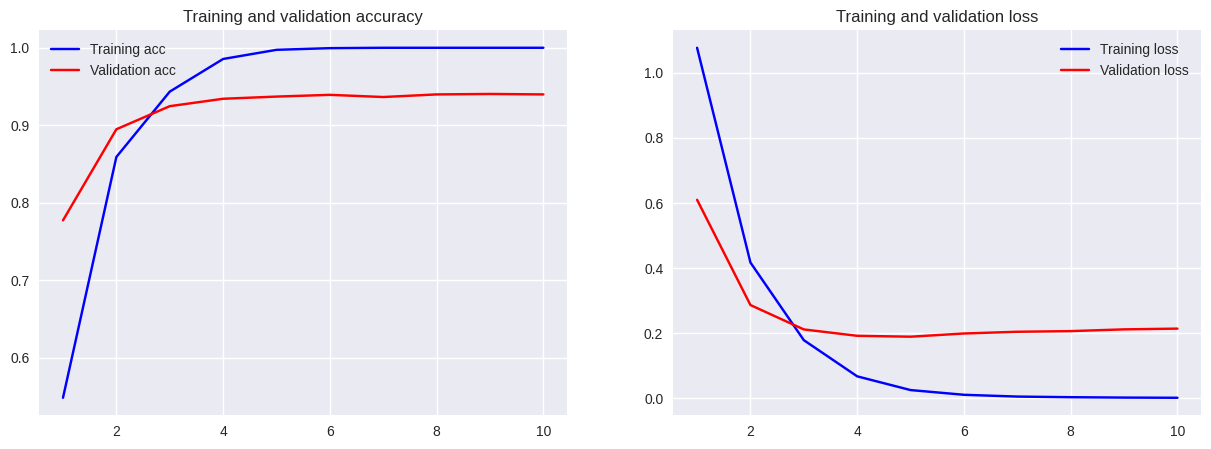

In [17]:
plot_history(history)

In [18]:
loss, accuracy = model.evaluate_generator(train_ds,32, workers=12)
print("Train: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-18-65c407442acf>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(train_ds,32, workers=12)


Train: accuracy = 0.995117  ;  loss = 0.016275 


In [19]:
loss, accuracy = model.evaluate_generator(val_ds,32, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-19-aa35ef486c7b>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(val_ds,32, workers=12)


Validation: accuracy = 0.940430  ;  loss = 0.211146 


In [20]:
# Save the entire model
model.save("/content/drive/MyDrive/FYP/InceptionV3.h5")

In [21]:

np.save('/content/drive/MyDrive/FYP/InceptionV3.npy', history.history)
# Save the training history as JSON
import json

with open("/content/drive/MyDrive/FYP/InceptionV3.json", "w") as f:
    json.dump(history.history, f)

# Save the training history as CSV
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv("/content/drive/MyDrive/FYP/InceptionV3.csv", index=False)


In [22]:
# Load the training history from the CSV file
history_df = pd.read_csv("/content/drive/MyDrive/FYP/InceptionV3.csv")

# Print the training and validation accuracy and loss from the history
print("Training History:")
print(history_df[['accuracy', 'loss']])
print("\nValidation History:")
print(history_df[['val_accuracy', 'val_loss']])

Training History:
   accuracy      loss
0  0.548302  1.076964
1  0.859070  0.417171
2  0.943387  0.178677
3  0.985546  0.067580
4  0.997350  0.025400
5  0.999518  0.010916
6  1.000000  0.005427
7  1.000000  0.003506
8  1.000000  0.002332
9  1.000000  0.001729

Validation History:
   val_accuracy  val_loss
0      0.777278  0.609978
1      0.894826  0.286584
2      0.924634  0.211680
3      0.934196  0.192107
4      0.937008  0.189355
5      0.939258  0.199240
6      0.936445  0.204523
7      0.939820  0.206529
8      0.940382  0.211922
9      0.939820  0.214173


In [23]:
yp_train = model.predict(train_ds)
yp_train = np.argmax(yp_train, axis=-1)
print(yp_train)

130/130 [==============================] - 10s 68ms/step
[2 0 2 ... 2 2 0]


In [24]:
true_categories = tf.concat([y for x, y in train_ds], axis=0)

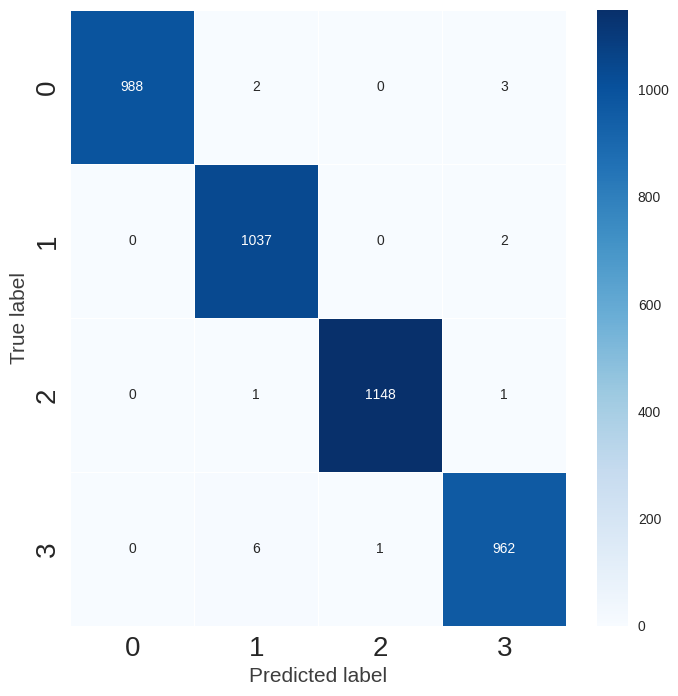

In [25]:
cm = confusion_matrix(true_categories,yp_train)

f, ax = plt.subplots(figsize =(8,8))
ax.tick_params(labelsize=20)
sns.heatmap(cm,annot = True,linewidths=0.5,fmt = ".0f",ax=ax ,cmap='Blues')
plt.ylabel('True label',fontsize=15,color="#3d3d3d")
plt.xlabel('Predicted label',fontsize=15,color="#3d3d3d")
plt.savefig("training_confusion_matrix.jpg")
plt.show()

In [26]:
print(classification_report(true_categories,yp_train))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       993
           1       0.99      1.00      0.99      1039
           2       1.00      1.00      1.00      1150
           3       0.99      0.99      0.99       969

    accuracy                           1.00      4151
   macro avg       1.00      1.00      1.00      4151
weighted avg       1.00      1.00      1.00      4151



In [27]:
yp_test = model.predict(val_ds)
yp_test = np.argmax(yp_test, axis=-1)
print(yp_test)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

56/56 [==============================] - 4s 67ms/step
[2 0 1 ... 3 1 1]


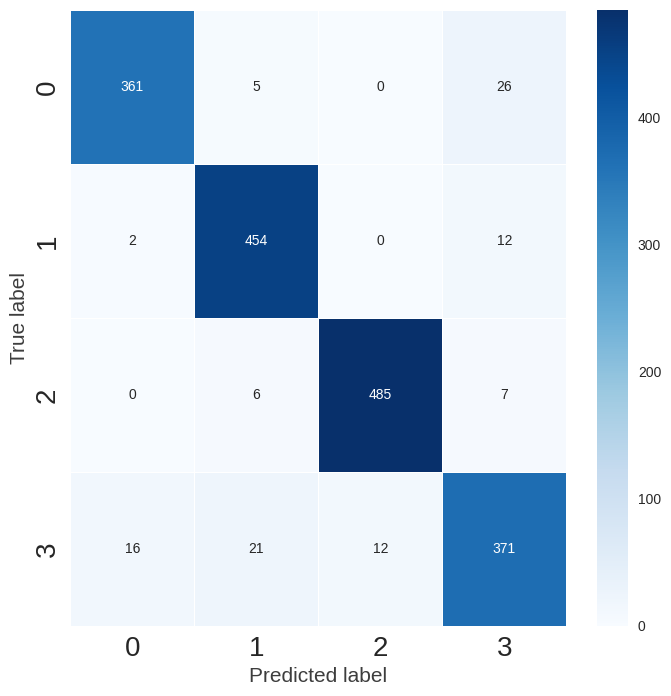

In [28]:
cm = confusion_matrix(true_categories,yp_test)

f, ax = plt.subplots(figsize =(8,8))
ax.tick_params(labelsize=20)
sns.heatmap(cm,annot = True,linewidths=0.5,fmt = ".0f",ax=ax ,cmap='Blues')
plt.ylabel('True label',fontsize=15,color="#3d3d3d")
plt.xlabel('Predicted label',fontsize=15,color="#3d3d3d")
plt.savefig("validation_confusion_matrix.svg")
plt.show()

In [29]:
print("             ************* Test Data ********************")
print(classification_report(true_categories,yp_test))

             ************* Test Data ********************
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       392
           1       0.93      0.97      0.95       468
           2       0.98      0.97      0.97       498
           3       0.89      0.88      0.89       420

    accuracy                           0.94      1778
   macro avg       0.94      0.94      0.94      1778
weighted avg       0.94      0.94      0.94      1778

